### Import stuff

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint

In [7]:
import sys  
sys.path.insert(0, '/home/jupyter/InternalVariability/AdaptationAnalysis')

In [8]:
from app.main.src.climate_projection import ClimateProjection
from app.main.src.year_of_departure import *
from app.main.src.datasets import *
from app.main.src.post_processing import BiasCorrection

### CMIP6 analysis for a single location

In [4]:
# set lat/lon
lat = 40
lon = -92

In [5]:
# get datasets via ClimateProjection workflow
# do monthly data first (using daily takes a while to load)
cp = ClimateProjection(
    lat=lat,
    lon=lon,
    variables=['t2m', 't2m_max', 't2m_min', 'tp'],    #TO-DO: figure out what the variables mean
    scenario='ssp585',
#     n_models=5,
    projection_name='demo_midwest_new_pp',
    gcs_bucket='climateai_data_repository',      #TO-DO: have this part explained again 
    gcs_path='tmp/analog_test',
    overwrite=True,
    daily=False
)

In [6]:
# load the data
#cross validate should always be false
cp.load(cross_validate=False,check_exist=False)

Computing demo_midwest_new_pp


some of the datasets that come out are raw_hist_monthly, reanalysis_monthly, pp_hist_monthly, pp_future-monthly

## Reproduce HS09
Here we will reproduce the model uncertainty and internal varaibility estimates using methodology from HS09 (i.e. fitting the data with a 4th order polynomial) 

### Prepare the data 

In [12]:
# concat the post-processed historical and future datasets 
# resample yearly (AS = yearly resample at the beginning of the calendar year)
# drop models that do not have the t2m variable 
data = xr.concat(
    [cp.pp_hist_monthly, cp.pp_future_monthly], dim='time'
).resample(time='AS').mean().t2m.dropna('model')

In [13]:
data

<xarray.DataArray 't2m' (time: 122, model: 14)>
array([[12.80702876, 10.8665568 , 11.4368751 , ..., 10.61267695,
        11.29070073, 11.91563082],
       [10.45318225, 12.05446122, 11.56253018, ..., 12.32510656,
        10.76854745, 11.736144  ],
       [11.52196175, 11.92011804, 12.88097297, ..., 11.63743896,
        11.37596178, 12.21003692],
       ...,
       [18.58469057, 18.25953482, 20.27516892, ..., 18.44978364,
        17.0302998 , 17.08717538],
       [19.81193865, 18.94265993, 20.33955448, ..., 17.2615938 ,
        17.11639865, 17.16640797],
       [19.73400534, 19.05688751, 19.41533316, ..., 18.05800872,
        15.8328444 , 17.06299653]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2100-01-01
  * model    (model) <U16 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'MRI-ESM2-0' 'NESM3'
    lat      int64 40
    lon      int64 -92

In [14]:
# take a decadal rolling average and drop times
data = data.rolling(time=10, center=True).mean().dropna('time')

In [15]:
data

<xarray.DataArray 't2m' (time: 113, model: 14)>
array([[11.64275126, 11.19465955, 11.93733924, ..., 11.85884715,
        11.33259217, 11.37736121],
       [11.41319847, 11.26591296, 12.02136761, ..., 11.95866715,
        11.31655836, 11.22709906],
       [11.46423366, 11.17926961, 11.94830018, ..., 11.732247  ,
        11.39287832, 11.14087136],
       ...,
       [18.92052897, 17.82052961, 19.45264328, ..., 17.63490121,
        17.33833426, 17.38030582],
       [19.0133199 , 17.98323378, 19.49264579, ..., 17.57109777,
        17.31396908, 17.42538259],
       [19.07643935, 18.18960079, 19.53479303, ..., 17.63426767,
        17.16212366, 17.37019274]])
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1985-01-01 ... 2096-01-01
  * model    (model) <U16 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'MRI-ESM2-0' 'NESM3'
    lat      int64 40
    lon      int64 -92

### Do the 4th order polynomial fit 

In [16]:
# create X and Y variables for the model fit 
X = np.arange(len(data.time))    # x variable is length of time
Y = data.values  # y is the temp data 

In [17]:
# the polynomial fit (4th order)
Z = np.polyfit(X,Y,4)

In [18]:
Z.shape   # why is this the shape of Z, is it because of the polynomial order?


(5, 14)

In [20]:
# make a copy of the data to do the fit using the coefs from Z 
fit = data.copy()

In [21]:
# is this a trick to avoid appending?? why isnt the m used in the for loop?
# what exactly are we doing here? Are we just constructing the fits for each of the models?
for i, m in enumerate(fit.model):
    p = np.poly1d(Z[:,i])
    fit[:, i] = p(X)

In [22]:
fit

<xarray.DataArray 't2m' (time: 113, model: 14)>
array([[11.29596485, 10.87039603, 11.59639678, ..., 11.37209452,
        11.23025879, 11.1220236 ],
       [11.32907235, 10.96398368, 11.5714094 , ..., 11.42641713,
        11.26163804, 11.17047892],
       [11.36327892, 11.05550109, 11.55112011, ..., 11.47771005,
        11.29546163, 11.21971156],
       ...,
       [19.05180728, 17.95491274, 19.63169908, ..., 17.72105252,
        17.43563317, 17.4855315 ],
       [19.16992267, 18.02915775, 19.82589671, ..., 17.80866267,
        17.54676039, 17.56939513],
       [19.28968439, 18.10342402, 20.02612828, ..., 17.89452491,
        17.66205181, 17.6549753 ]])
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1985-01-01 ... 2096-01-01
  * model    (model) <U16 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'MRI-ESM2-0' 'NESM3'
    lat      int64 40
    lon      int64 -92

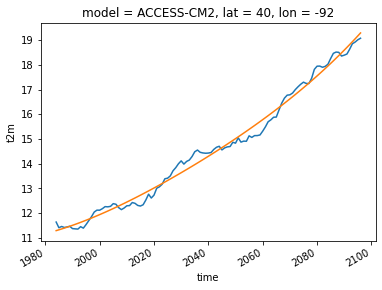

In [23]:
#plot a model and model fit 
data.isel(model=0).plot()
fit.isel(model=0).plot()

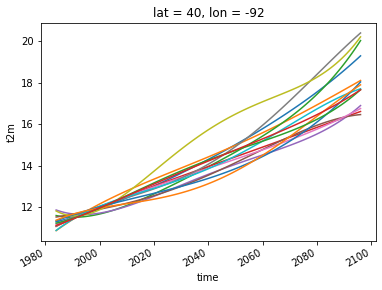

In [24]:
fit.plot(hue='model',add_legend=False);

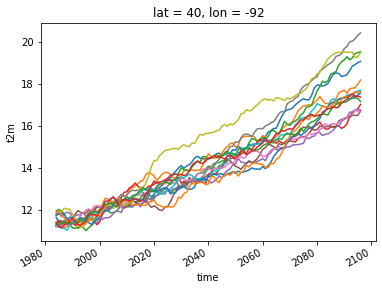

In [25]:
data.plot(hue='model', add_legend=False);

#### calculate residual 

In [26]:
residual = data - fit 

In [27]:
internal = residual.var('time').mean('model')

In [28]:
model = fit.var('model')

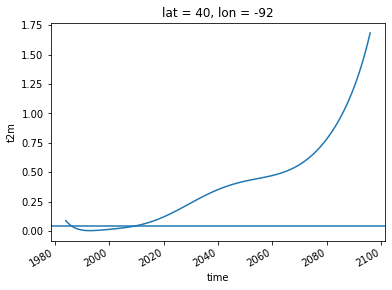

In [29]:
model.plot()
plt.axhline(internal)

In [30]:
model.time

<xarray.DataArray 'time' (time: 113)>
array(['1984-01-01T00:00:00.000000000', '1985-01-01T00:00:00.000000000',
       '1986-01-01T00:00:00.000000000', '1987-01-01T00:00:00.000000000',
       '1988-01-01T00:00:00.000000000', '1989-01-01T00:00:00.000000000',
       '1990-01-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1993-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '1997-01-01T00:00:00.000000000',
       '1998-01-01T00:00:00.000000000', '1999-01-01T00:00:00.000000000',
       '2000-01-01T00:00:00.000000000', '2001-01-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2004-01-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2006-01-01T00:00:00.000000000', '2007-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '2009-01-01T00:00:00.000000000',
       '2010-01-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2012-01-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2014-01-01T00:00:00.000000000', '2015-01-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2017-01-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2022-01-01T00:00:00.000000000', '2023-01-01T00:00:00.000000000',
       '2024-01-01T00:00:00.000000000', '2025-01-01T00:00:00.000000000',
       '2026-01-01T00:00:00.000000000', '2027-01-01T00:00:00.000000000',
       '2028-01-01T00:00:00.000000000', '2029-01-01T00:00:00.000000000',
       '2030-01-01T00:00:00.000000000', '2031-01-01T00:00:00.000000000',
       '2032-01-01T00:00:00.000000000', '2033-01-01T00:00:00.000000000',
       '2034-01-01T00:00:00.000000000', '2035-01-01T00:00:00.000000000',
       '2036-01-01T00:00:00.000000000', '2037-01-01T00:00:00.000000000',
       '2038-01-01T00:00:00.000000000', '2039-01-01T00:00:00.000000000',
       '2040-01-01T00:00:00.000000000', '2041-01-01T00:00:00.000000000',
       '2042-01-01T00:00:00.000000000', '2043-01-01T00:00:00.000000000',
       '2044-01-01T00:00:00.000000000', '2045-01-01T00:00:00.000000000',
       '2046-01-01T00:00:00.000000000', '2047-01-01T00:00:00.000000000',
       '2048-01-01T00:00:00.000000000', '2049-01-01T00:00:00.000000000',
       '2050-01-01T00:00:00.000000000', '2051-01-01T00:00:00.000000000',
       '2052-01-01T00:00:00.000000000', '2053-01-01T00:00:00.000000000',
       '2054-01-01T00:00:00.000000000', '2055-01-01T00:00:00.000000000',
       '2056-01-01T00:00:00.000000000', '2057-01-01T00:00:00.000000000',
       '2058-01-01T00:00:00.000000000', '2059-01-01T00:00:00.000000000',
       '2060-01-01T00:00:00.000000000', '2061-01-01T00:00:00.000000000',
       '2062-01-01T00:00:00.000000000', '2063-01-01T00:00:00.000000000',
       '2064-01-01T00:00:00.000000000', '2065-01-01T00:00:00.000000000',
       '2066-01-01T00:00:00.000000000', '2067-01-01T00:00:00.000000000',
       '2068-01-01T00:00:00.000000000', '2069-01-01T00:00:00.000000000',
       '2070-01-01T00:00:00.000000000', '2071-01-01T00:00:00.000000000',
       '2072-01-01T00:00:00.000000000', '2073-01-01T00:00:00.000000000',
       '2074-01-01T00:00:00.000000000', '2075-01-01T00:00:00.000000000',
       '2076-01-01T00:00:00.000000000', '2077-01-01T00:00:00.000000000',
       '2078-01-01T00:00:00.000000000', '2079-01-01T00:00:00.000000000',
       '2080-01-01T00:00:00.000000000', '2081-01-01T00:00:00.000000000',
       '2082-01-01T00:00:00.000000000', '2083-01-01T00:00:00.000000000',
       '2084-01-01T00:00:00.000000000', '2085-01-01T00:00:00.000000000',
       '2086-01-01T00:00:00.000000000', '2087-01-01T00:00:00.000000000',
       '2088-01-01T00:00:00.000000000', '2089-01-01T00:00:00.000000000',
       '2090-01-01T00:00:00.000000000', '2091-01-01T00:00:00.000000000',
       '2092-01-01T0

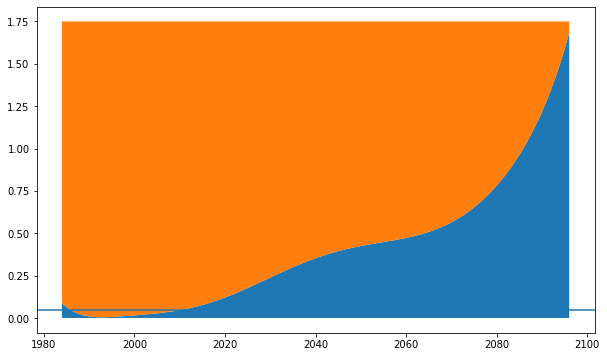

In [31]:
figure = plt.figure(figsize=(10,6))
x = model.time
y = model
plt.fill_between(x,y)
plt.axhline(internal)
plt.fill_between(x,y,1.75)

In [34]:
total = internal + model 

In [35]:
internal_frac = (internal/total)*100
model_frac = (model/total)*100

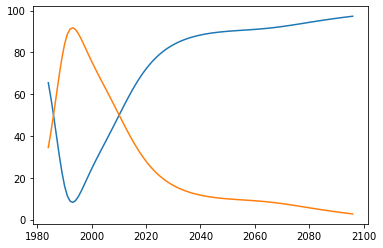

In [37]:
plt.plot(model_frac.time,model_frac)
plt.plot(internal_frac.time,internal_frac)

### Look at global

In [49]:
lat = slice(None, None)
lon = slice(None, None)

In [50]:
lat

slice(None, None, None)

In [51]:
# get datasets via ClimateProjection workflow
# do monthly data first (using daily takes a while to load)
cp = ClimateProjection(
    lat=lat,
    lon=lon,
    variables=['t2m', 't2m_max', 't2m_min', 'tp'],    #TO-DO: figure out what the variables mean
    scenario='ssp585',
#     n_models=5,
    projection_name='demo_midwest_new_pp',
    gcs_bucket='climateai_data_repository',      #TO-DO: have this part explained again 
    gcs_path='tmp/analog_test',
    overwrite=True,
    daily=False
)

TypeError: '>' not supported between instances of 'slice' and 'int'